In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.stats import norm

# Base Constants
H_0 = 70  # km/s/Mpc
c = 2.99792458e5  # km/s
M = -19.3146267582  # SN Absolute Magnitude
M_n = 25 - 5*np.log10(H_0) #Script_M
Omega_R = 1e-8 

# Test Guess Constants
Omega_M = 0.27
Omega_DE = 0.73
Omega_K = 0.0001
w = -1
k = 0

# Supernova Data

data = pd.read_csv('SCPUnion2.1_mu_vs_z.txt', sep='\t', comment='#', usecols=[0, 1, 2, 3], names=['SNe', 'z', 'm', 'm_err'])


# Covariance matrix

data_cov = pd.read_csv('SCPUnion2.1_covmat_nosys.txt', sep=r'\s+', header=None)


# Calculation of r(z)

def integrand(z, Omega_M, Omega_DE, w, Omega_K, k):
    return 1 / (H_0 * np.sqrt(Omega_M * (1 + z)**(3) + Omega_DE * (1 + z)**(3 * (1 + w)) + Omega_R * (1 + z)**(4) - Omega_K * (1 + z)**(2)))

def r(z, Omega_M, Omega_DE, w, Omega_K, k):
    r_0 = 1 / (H_0 * np.sqrt(np.abs(Omega_K)))
    if k == 1:
        return c * r_0 * np.sin(quad(integrand, 0, z, args=(Omega_M, Omega_DE, w, Omega_K, k))[0] / r_0)
    elif k == 0:
        return c * quad(integrand, 0, z, args=(Omega_M, Omega_DE, w, Omega_K, k))[0]
    elif k == -1:
        return c * r_0 * np.sinh(quad(integrand, 0, z, args=(Omega_M, Omega_DE, w, Omega_K, k))[0] / r_0)

# Calculation of d_l

def d_L(z, Omega_M, Omega_DE, w, Omega_K, k):
    return (1 + z) * r(z, Omega_M, Omega_DE, w, Omega_K, k)

# Calculation of m(z, {pj})

def m_th(z, Omega_M, Omega_DE, w, M_n, Omega_K, k):
    return 5 * np.log10(H_0*d_L(z, Omega_M, Omega_DE, w, Omega_K, k)) + M_n

# Calculation of (m - m^th)
def m_diff_vector(z, Omega_M, Omega_DE, w, M_n, Omega_K, k):

    data['m_th'] = data['z'].apply(lambda z: m_th(z, Omega_M, Omega_DE, w, M_n, Omega_K, k))
    data['m_diff'] = data['m'] - data['m_th']
    return data['m_diff']

m_diff_vector(data['z'], Omega_M, Omega_DE, w, M_n, Omega_K, k)

0     -0.133792
1     -0.056714
2     -0.047660
3     -0.055663
4      0.235631
         ...   
575    0.108170
576    0.088156
577    0.034536
578    0.577946
579   -0.351542
Name: m_diff, Length: 580, dtype: float64

In [5]:
def fisher_matrix(data, params, vary_params, k=0):
    param_keys = list(vary_params)
    n_params = len(param_keys)
    fisher = np.zeros((n_params, n_params))
    h = 1e-5
    
    for i in range(n_params):
        for j in range(n_params):
            base_params = params.copy()

            # Modify parameters i and j
            base_params[param_keys[i]] += h
            m_th1 = data['z'].apply(lambda z: m_th(z, **base_params, Omega_K=0.0001, k=k))

            base_params[param_keys[i]] -= 2 * h
            m_th2 = data['z'].apply(lambda z: m_th(z, **base_params, Omega_K=0.0001, k=k))

            # Reset to original
            base_params[param_keys[i]] += h
            
            # Central difference for partial derivatives
            dm_dpi = (m_th1 - m_th2) / (2 * h)

            if i == j:  # Diagonal elements, derivative wrt same parameter
                fisher[i, j] = np.sum((dm_dpi**2) / (data['m_err']**2))
            else:  # Off-diagonal elements, mixed partial derivatives
                base_params[param_keys[j]] += h
                m_th1 = data['z'].apply(lambda z: m_th(z, **base_params, Omega_K=0.0001, k=k))

                base_params[param_keys[j]] -= 2 * h
                m_th2 = data['z'].apply(lambda z: m_th(z, **base_params, Omega_K=0.0001, k=k))

                dm_dpj = (m_th1 - m_th2) / (2 * h)
                fisher[i, j] = np.sum((dm_dpi * dm_dpj) / (data['m_err']**2))

    return fisher

# Define parameters
params = {'Omega_M': 0.278, 'Omega_DE': 0.722, 'w': -1, 'M_n': 25 - 5 * np.log10(70)}

# Define which parameters vary for k=0
vary_params_flat = ['Omega_M', 'w', 'M_n']
F_flat = fisher_matrix(data, params, vary_params_flat, k=0)

print("Fisher Matrix (Flat Universe):")
print(F_flat)

Fisher Matrix (Flat Universe):
[[ 38115.60602495   5908.65033867 -26722.06773794]
 [  5908.65033867   1112.78055395  -3795.8351101 ]
 [-26722.06773794  -3795.8351101   19434.07720832]]


In [19]:
# Calculation of Chi^2 (With FIM variance)

def chi_squared(cov, Omega_M, Omega_DE, w, Omega_K, k):
# Convert the covariance matrix to a numpy array
    cov_matrix = cov

    # Invert the covariance matrix
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    # Calculate the chi-squared value
    chi_squared1 = np.dot(data['m_diff'], np.dot(inv_cov_matrix, m_diff_vector(data['z'], Omega_M, Omega_DE, w, M_n, Omega_K, k)))

    return chi_squared1

chi_squared(data_cov.values, Omega_M, Omega_DE, w, Omega_K, k)

562.4079631821645

In [20]:
# Calculation of the likelihood

def log_likelihood(cov, Omega_M, Omega_DE, w, Omega_K, k):
    # Calculate the log of the determinant and the sign of the determinant for the regularized matrix
    sign, log_det = np.linalg.slogdet(cov)

    n = cov.shape[0]

    

    log_likelihood1 = -0.5 * n * np.log(2 * np.pi) - 0.5 * log_det - 0.5 * chi_squared(cov, Omega_M, Omega_DE, w, Omega_K, k)

    return log_likelihood1

log_likelihood(data_cov.values, 0.25, 0.75, -0.985, 0.0001, 0)

118.64961335732488

Most likely Omega_M: 0.2717171717171717
Most likely Omega_DE: 0.7282828282828283
Most likely Omega_M (array max): 0.2714214214214214
68% confidence interval goes up to: 0.2782828282828283
95% confidence interval goes up to: 0.2924242424242424


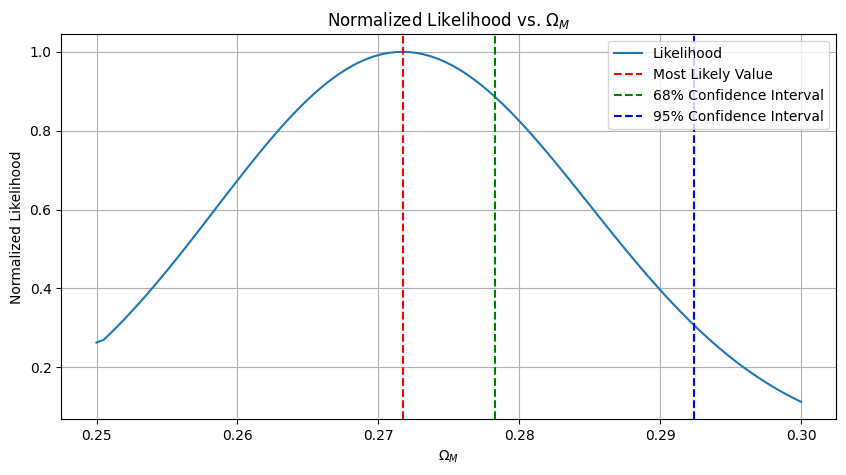

In [21]:
# Case 1: Varying Omega_M, w = const

# Fixed values
w = -0.985 # From Union 2.1 paper
Omega_K = 0.0001
k = 0

# Define min and max Omega_M for the range
min_omega_m = 0.25
max_omega_m = 0.30
omega_m_range = np.linspace(min_omega_m, max_omega_m, 100)

# Calculate, normalize likelihoods
likelihoods_m = np.array([log_likelihood(data_cov.values, omega_m, (1 - omega_m - Omega_K - Omega_R), w, Omega_K, k) for omega_m in omega_m_range])


likelihoods_m_norm = np.exp(likelihoods_m - np.max(likelihoods_m))

# Fit a polynomial to the normalized likelihood data
coefficients = np.polyfit(omega_m_range, likelihoods_m_norm, 5)
polynomial = np.poly1d(coefficients)

# Sample the polynomial within the omega_m_range
x_fine = np.linspace(min_omega_m, max_omega_m, 1000)
y_fine = polynomial(x_fine)

# Maximum likelihood value
max_x = x_fine[np.argmax(y_fine)]
most_likely_omega_m = omega_m_range[np.argmax(likelihoods_m_norm)]

# Most likely values
print("Most likely Omega_M:", most_likely_omega_m)
print("Most likely Omega_DE:", 1 - most_likely_omega_m)
print("Most likely Omega_M (array max):", max_x)

# Calculate confidence intervals
cumulative_m_likelihood = np.cumsum(likelihoods_m_norm)
cumulative_m_likelihood /= cumulative_m_likelihood[-1]  # Normalize to sum to 1

index_68 = np.where(cumulative_m_likelihood >= 0.68)[0][0]
index_95 = np.where(cumulative_m_likelihood >= 0.95)[0][0]
omega_m_68 = omega_m_range[index_68]
omega_m_95 = omega_m_range[index_95]

# Confidence interval bounds
print("68% confidence interval goes up to:", omega_m_68)
print("95% confidence interval goes up to:", omega_m_95)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(omega_m_range, likelihoods_m_norm, label='Likelihood')
plt.axvline(x=most_likely_omega_m, color='r', linestyle='--', label='Most Likely Value')
plt.axvline(x=omega_m_68, color='g', linestyle='--', label='68% Confidence Interval')
plt.axvline(x=omega_m_95, color='b', linestyle='--', label='95% Confidence Interval')
plt.title('Normalized Likelihood vs. $\\Omega_M$')
plt.xlabel('$\\Omega_M$')
plt.ylabel('Normalized Likelihood')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
print("All likelihood values:", likelihoods_m)

All likelihood values: [117.39640178 117.42121189 117.48381927 117.54485367 117.60431839
 117.6622167  117.71855188 117.77332719 117.82654588 117.87821117
 117.92832631 117.97689452 118.02391899 118.06940293 118.11334953
 118.15576197 118.19664341 118.23599701 118.27382592 118.31013327
 118.34492221 118.37819585 118.40995729 118.44020963 118.46895597
 118.49619939 118.52194296 118.54618973 118.56894276 118.5902051
 118.60997978 118.62826981 118.64507822 118.66040801 118.67426218
 118.68664371 118.69755558 118.70700075 118.7149822  118.72150287
 118.7265657  118.73017362 118.73232956 118.73303643 118.73229714
 118.73011459 118.72649166 118.72143123 118.71493618 118.70700937
 118.69765365 118.68687186 118.67466685 118.66104144 118.64599845
 118.6295407  118.61167097 118.59239208 118.57170681 118.54961793
 118.52612821 118.50124042 118.47495731 118.44728162 118.4182161
 118.38776346 118.35592644 118.32270774 118.28811007 118.25213612
 118.21478859 118.17607015 118.13598349 118.09453126 11

Most likely w: -1.1
Most likely w (array max): -1.1
68% confidence interval for w goes up to: -1.1
95% confidence interval for w goes up to: -0.9888888888888889


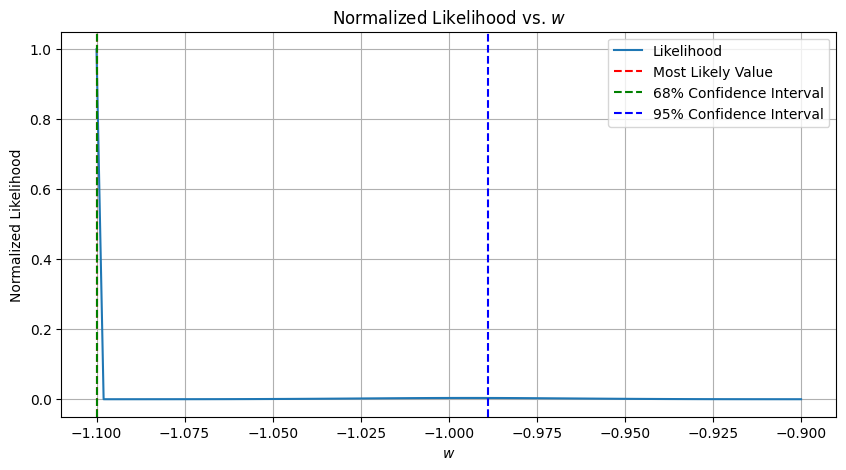

In [25]:
# Case 1: Varying w, Omega_M = const

# Fixed values
fixed_omega_m = 0.276 # From Union 2.1 paper
fixed_omega_de = 1 - fixed_omega_m - Omega_K - Omega_R
Omega_K = 0.0001
k = 0

# Define min and max w for the range
min_w = -1.1
max_w = -0.9
w_range = np.linspace(min_w, max_w, 100)

# Calculate, normalize likelihoods
likelihoods_w = np.array([log_likelihood(data_cov.values, fixed_omega_m, fixed_omega_de, w_val, Omega_K, k) for w_val in w_range])

likelihoods_w_norm = np.exp(likelihoods_w - np.max(likelihoods_w))

# Fit a polynomial to the normalized likelihood data
coefficients_w = np.polyfit(w_range, likelihoods_w_norm, 5)
polynomial_w = np.poly1d(coefficients_w)

# Sample the polynomial within the omega_m_range
x_fine_w = np.linspace(min_w, max_w, 1000)
y_fine_w = polynomial_w(x_fine_w)

# Maximum likelihood value
max_x_w = x_fine_w[np.argmax(y_fine_w)]
most_likely_w = w_range[np.argmax(likelihoods_w_norm)]

# Most likely values
most_likely_w = w_range[np.argmax(likelihoods_w_norm)]
print("Most likely w:", most_likely_w)
print("Most likely w (array max):", max_x_w)

# Calculate confidence intervals
cumulative_likelihood_w = np.cumsum(likelihoods_w_norm)
cumulative_likelihood_w /= cumulative_likelihood_w[-1]

index_68_w = np.where(cumulative_likelihood_w >= 0.68)[0][0]
index_95_w = np.where(cumulative_likelihood_w >= 0.95)[0][0]

w_68 = w_range[index_68_w]
w_95 = w_range[index_95_w]

# Confidence interval values
print("68% confidence interval for w goes up to:", w_68)
print("95% confidence interval for w goes up to:", w_95)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(w_range, likelihoods_w_norm, label='Likelihood')
plt.axvline(x=most_likely_w, color='r', linestyle='--', label='Most Likely Value')
plt.axvline(x=w_68, color='g', linestyle='--', label='68% Confidence Interval')
plt.axvline(x=w_95, color='b', linestyle='--', label='95% Confidence Interval')
plt.title('Normalized Likelihood vs. $w$')
plt.xlabel('$w$')
plt.ylabel('Normalized Likelihood')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
print("All likelihood values:", likelihoods_w)

All likelihood values: [122.32930237 112.96146665 113.18079807 113.39605546 113.60722875
 113.81430784 114.01728264 114.21614303 114.41087887 114.60148002
 114.78793631 114.97023756 115.14837359 115.32233417 115.49210909
 115.65768811 115.81906097 115.9762174  116.12914711 116.27783981
 116.42228518 116.56247289 116.69839259 116.83003393 116.95738652
 117.08043998 117.19918391 117.31360787 117.42370145 117.52945419
 117.63085562 117.72789526 117.82056263 117.90884722 117.9927385
 118.07222593 118.14729897 118.21794705 118.28415959 118.34592599
 118.40323565 118.45607794 118.50444223 118.54831786 118.58769417
 118.62256047 118.65290609 118.67872029 118.69999238 118.71671161
 118.72886722 118.73644846 118.73944456 118.73784471 118.73163812
 118.72081397 118.70536142 118.68526964 118.66052775 118.6311249
 118.59705019 118.55829273 118.5148416  118.46668588 118.41381464
 118.35621691 118.29388174 118.22679814 118.15495514 118.07834172
 117.99694686 117.91075955 117.81976873 117.72396336 11

In [41]:
# Differences in computed values to Union 2.1 values:
omega_m_diff = np.abs(fixed_omega_m - most_likely_omega_m)
w_diff = np.abs(w - most_likely_w)
print("Diff in Omega_M:", omega_m_diff)
print("Diff in w:", w_diff)

# Percentage error
omega_m_pe = omega_m_diff/fixed_omega_m * 100
w_pe = w_diff/w * 100
print("% err in Omega_M:", omega_m_pe, "%")
print("% err in w:", w_pe, "%")

Diff in Omega_M: 0.004282828282828333
Diff in w: 0.009949494949495041
% err in Omega_M: 1.5517493778363523 %
% err in w: -1.0101010101010193 %


Most likely Omega_M: 0.28060606060606064
Most likely w: -1.0050505050505052


ValueError: Contour levels must be increasing

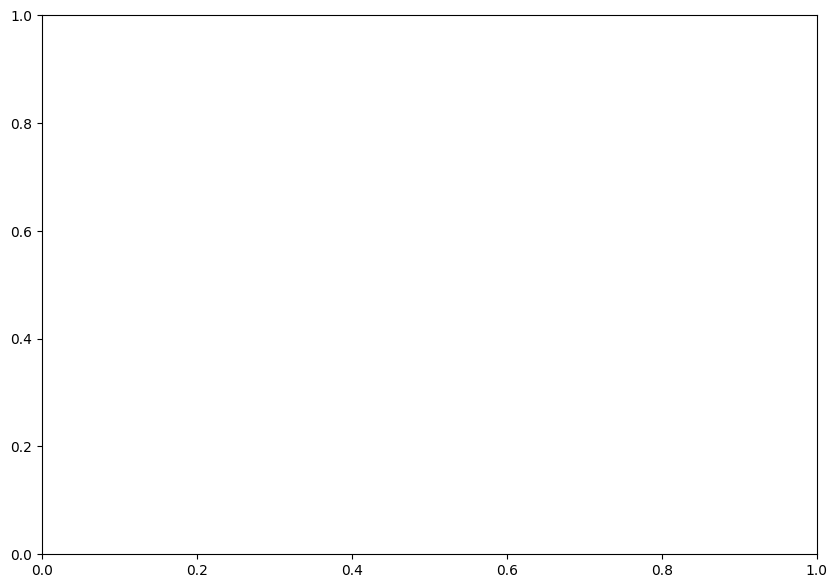

In [27]:
# Case 1: Varying w, Omega_M

# Fixed values
Omega_K = 0.0001
k = 0

# Define ranges for Omega_M and w
omega_m_min, omega_m_max = 0.22, 0.34
w_min, w_max = -1.1, -0.9
omega_m_range = np.linspace(omega_m_min, omega_m_max, 100)
w_range = np.linspace(w_min, w_max, 100)

# Create meshgrid for Omega_M and w
Omega_M_grid, w_grid = np.meshgrid(omega_m_range, w_range)

# Calculate, normalize likelihoods
likelihoods = np.array([log_likelihood(data_cov.values, Omega_M, 1 - Omega_M - Omega_K - Omega_R, w, Omega_K, k) 
                        for Omega_M, w in zip(np.ravel(Omega_M_grid), np.ravel(w_grid))])
likelihoods = likelihoods.reshape(Omega_M_grid.shape)

for row in likelihoods: # Resolve bug in abnormal dips/increases in likelihood
    row[0] = row[1]

likelihoods_norm = np.exp(likelihoods - np.max(likelihoods))

# Most likely values calculation
index_max = np.argmax(likelihoods_norm)
max_index = np.unravel_index(index_max, likelihoods_norm.shape)
most_likely_omega_m = Omega_M_grid[max_index]
most_likely_w = w_grid[max_index]

print("Most likely Omega_M:", most_likely_omega_m)
print("Most likely w:", most_likely_w)

# Normalize the likelihoods to sum to 1
cumulative_likelihood = np.cumsum(np.cumsum(likelihoods_norm, axis=0), axis=1)
cumulative_likelihood /= cumulative_likelihood[-1, -1]

# Calculate the percentage levels for the confidence intervals
sorted_likelihoods = np.sort(likelihoods_norm.ravel())
cumulative_sum = np.cumsum(sorted_likelihoods)
norm_cumulative_sum = cumulative_sum / cumulative_sum[-1]

# Find the closest entries to 68% and 95% confidence levels
level_95 = sorted_likelihoods[np.searchsorted(norm_cumulative_sum, 0.68)]
level_68 = sorted_likelihoods[np.searchsorted(norm_cumulative_sum, 0.95)]

# Plotting the contour with confidence intervals
plt.figure(figsize=(10, 7))
cp = plt.contour(Omega_M_grid, w_grid, likelihoods_norm, levels=[level_68, level_95], colors=['blue', 'red'])
plt.scatter([most_likely_omega_m], [most_likely_w], color='yellow', label='Most Likely Values', zorder=5)
plt.clabel(cp, inline=True, fontsize=10, fmt={level_68: '68%', level_95: '95%'})
plt.title('Confidence Intervals on the Omega_M vs. w Likelihood Surface')
plt.xlabel('Omega_M')
plt.ylabel('w')
plt.legend()
plt.grid(True)
plt.show()

# Swap confidence interval values
# Add in third loop for nuisance parameter - watch the runtime (36, 36, 10) - figure out if zip, unravel applies to 3D array

In [ ]:
x = np.arange(-5, 6, 1)
y = np.arange(-5, 6, 1)
xx, yy = np.meshgrid(x, y, sparse=True)
z = np.sin(xx**2 + yy**2) / (xx**2 + yy**2)
h = plt.contourf(x,y,z)